# Setup

## Libraries

Install:


*   imageio for GIF making.
*   kaggle for downloading dataset.

Import all libraries.

In [1]:
!pip install -U -q kaggle
!pip install kaggle --upgrade


Requirement already up-to-date: kaggle in c:\users\jordi\anaconda3\envs\tf_gpu\lib\site-packages (1.5.6)


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
from IPython import display

try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.optimizers import Adam
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import IPython.display as display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import glob
import imghdr
import imageio
import PIL
import pathlib
import time
import os
import json

Using TensorFlow backend.


In [3]:
tf.__version__

'2.1.0'

### Load and prepare the dataset

####Download dataset

Male Female attribute is "Male" in datasaet, -1 female, 1 male


####CelebA dataset Wrapper

Dataset wrapper for easy handling of attributes, paths and partitioning.

In [4]:
class CelebA():
  '''Wraps the celebA dataset, allowing an easy way to:
       - Select the features of interest,
       - Split the dataset into 'training', 'test' or 'validation' partition.
  '''
  def __init__(self, main_folder='celeba-dataset/', selected_features=None, drop_features=[]):
    self.main_folder = main_folder
    self.images_folder   = os.path.join(main_folder, 'img_align_celeba/')
    self.attributes_path = os.path.join(main_folder, 'list_attr_celeba.csv')
    self.partition_path  = os.path.join(main_folder, 'list_eval_partition.csv')
    self.selected_features = selected_features
    self.features_name = []
    self.__prepare(drop_features)

  def __prepare(self, drop_features):
    '''do some preprocessing before using the data: e.g. feature selection'''
    # attributes:
    if self.selected_features is None:
      self.attributes = pd.read_csv(self.attributes_path)
      self.num_features = 40
    else:
      self.num_features = len(self.selected_features)
      self.selected_features = self.selected_features.copy()
      self.selected_features.append('image_id')
      self.attributes = pd.read_csv(self.attributes_path)[self.selected_features]

    # remove unwanted features:
    for feature in drop_features:
      if feature in self.attributes:
        self.attributes = self.attributes.drop(feature, axis=1)
        self.num_features -= 1
      
    self.attributes.set_index('image_id', inplace=True)
    self.attributes.replace(to_replace=-1, value=0, inplace=True)
    self.attributes['image_id'] = list(self.attributes.index)
  
    self.features_name = list(self.attributes.columns)[:-1]
  
    # load ideal partitioning:
    self.partition = pd.read_csv(self.partition_path)
    self.partition.set_index('image_id', inplace=True)
  
  def split(self, name='training', drop_zero=False):
    '''Returns the ['training', 'validation', 'test'] split of the dataset'''
    # select partition split:
    if name is 'training':
      to_drop = self.partition.where(lambda x: x != 0).dropna()
    elif name is 'validation':
      to_drop = self.partition.where(lambda x: x != 1).dropna()
    elif name is 'test':  # test
      to_drop = self.partition.where(lambda x: x != 2).dropna()
    else:
      raise ValueError('CelebA.split() => `name` must be one of [training, validation, test]')

    partition = self.partition.drop(index=to_drop.index)
      
    # join attributes with selected partition:
    joint = partition.join(self.attributes, how='inner').drop('partition', axis=1)

    if drop_zero is True:
      # select rows with all zeros values
      return joint.loc[(joint[self.features_name] == 1).any(axis=1)]
    elif 0 <= drop_zero <= 1:
      zero = joint.loc[(joint[self.features_name] == 0).all(axis=1)]
      zero = zero.sample(frac=drop_zero)
      return joint.drop(index=zero.index)

    return joint

  def split_all(self, drop_zero=False):

    ret = []
    for i in range(3): 
      to_drop = self.partition.where(lambda x: x != i).dropna()
      partition = self.partition.drop(index=to_drop.index)
      joint = partition.join(self.attributes, how='inner').drop('partition', axis=1)

      if drop_zero is True:
        ret.append(joint.loc[(joint[self.features_name] == 1).any(axis=1)])
      elif 0 <= drop_zero <= 1:
        zero = joint.loc[(joint[self.features_name] == 0).all(axis=1)]
        zero = zero.sample(frac=drop_zero)
        ret.append(joint.drop(index=zero.index))

      ret.append(joint) 

    return ret[0], ret[1], ret[2]

####Prepare dataset

In [5]:
celeba = CelebA(selected_features=["Male"])

data_dir = pathlib.Path(celeba.images_folder + "")
image_count = len(list(data_dir.glob('*/*.jpg')))
image_list = list(data_dir.glob('*/*.jpg'))
image_list = [str(x) for x in image_list]
len(image_list)
print(len(list(data_dir.glob('*/*.jpg'))))

202599


In [6]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BUFFER_SIZE = 3000
BATCH_SIZE = 64
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
CLASS_NAMES = celeba.features_name

img_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
noise_shape = (100,)

In [7]:
def _parse_function(filename, labels):
  #Images are loaded and decoded
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string, channels=3)
  image = tf.cast(image_decoded, tf.float32)
  #img = load_image(filename)
  #Reshaping, normalization and optimization goes here
  image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = image/255.0 # Normalize the images to [-1, 1]
  return image, labels

In [8]:
#Labels and images are created
labels = celeba.attributes.drop('image_id', 1)
labels = labels.applymap(lambda x: 1 if x else 0) 
labels = tf.constant(labels.values, dtype=tf.dtypes.float32)

In [9]:
#Create data set and map it. Could be improved if we can load images previously
# and avoid mapping it later.
training_images = (tf.data.Dataset.from_tensor_slices((image_list[:10000], labels[:10000])))

In [10]:
training_dataset = training_images.map(_parse_function)

In [11]:
#Shuffle and batch
training_dataset = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
# for batch in training_dataset:
#   break

with tf.device('/device:GPU:0'):    
  for batch in training_dataset:
    break
  print(batch[0][0].device)

/job:localhost/replica:0/task:0/device:GPU:0


In [13]:
tf.test.gpu_device_name()

'/device:GPU:0'

#Test Mauro

In [14]:
class Generator(tf.keras.Model):

  def __init__(self, generator_input_shape=(100,)):
    super(Generator, self).__init__()
    self.generator_input_shape = generator_input_shape
    self.dense1 = layers.Dense(1024, activation="relu")
    self.dense2 = layers.Dense(128*8*8, activation="relu")
    self.reshape = layers.Reshape((8,8,128))

    self.unconv1 = layers.Conv2DTranspose(128, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)
    self.conv1 = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_4")

    self.unconv2 = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)
    self.conv2 = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_5")
        
    self.unconv3 = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)
    self.conv3 = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_6")

    self.unconv4 = layers.Conv2DTranspose(64, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)
    self.conv4 = layers.Conv2D( 128  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_7")

    self.img = layers.Conv2D( 3 , ( 1 , 1 ) , activation='sigmoid' , padding='same', name="final_block")

  def call(self, inputs):
    x = self.dense1(inputs)
    x = self.dense2(x)
    x = self.reshape(x)

    x = self.unconv1(x)
    x = self.conv1(x)

    x = self.unconv2(x)
    x = self.conv2(x)

    x = self.unconv3(x)
    x = self.conv3(x)

    x = self.unconv4(x)
    x = self.conv4(x)

    return self.img(x)

#https://github.com/tensorflow/tensorflow/issues/25036
  def model(self):
    x = layers.Input(shape=self.generator_input_shape)
    return models.Model(inputs=[x], outputs=self.call(x))



In [15]:
generator = Generator().model()
generator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.00007, 0.5))
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              103424    
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       65536     
_________________________________________________________________
block_4 (Conv2D)             (None, 16, 16, 64)        8256      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 32)        8192  

In [16]:
class Discriminator(tf.keras.Model):
  def __init__(self, input_shape, output_shape=1):
    super(Discriminator, self).__init__()
    self.discriminator_input_shape = input_shape
    self.conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')
    self.conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')
    self.maxpooling1 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')
    
    self.conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')
    self.conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')
    self.maxpooling2 = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')
    
    self.conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1')
    self.conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')
    self.maxpooling3 = layers.MaxPooling2D((2, 2), strides=(1, 1), name='block4_pool')

    
    self.flatten = layers.Flatten()
    self.dense1 = layers.Dense(1024,      activation="relu")
    self.dense2 = layers.Dense(output_shape,   activation='sigmoid')
  
  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.conv2(x)
    x = self.maxpooling1(x)

    x = self.conv3(x)
    x = self.conv4(x)
    x = self.maxpooling2(x)

    x = self.conv5(x)
    x = self.conv6(x)
    x = self.maxpooling3(x)

    x = self.flatten(x)
    x = self.dense1(x)
    return self.dense2(x)
  
  #https://github.com/tensorflow/tensorflow/issues/25036
  def model(self):
    x = layers.Input(shape=self.discriminator_input_shape)
    return models.Model(inputs=[x], outputs=self.call(x))

In [17]:
discriminator = Discriminator((IMG_HEIGHT, IMG_WIDTH, 3)).model()
discriminator.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.00007, 0.5), metrics   = ['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 32)      896       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 32)      9248      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 64)        18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 64)        0   

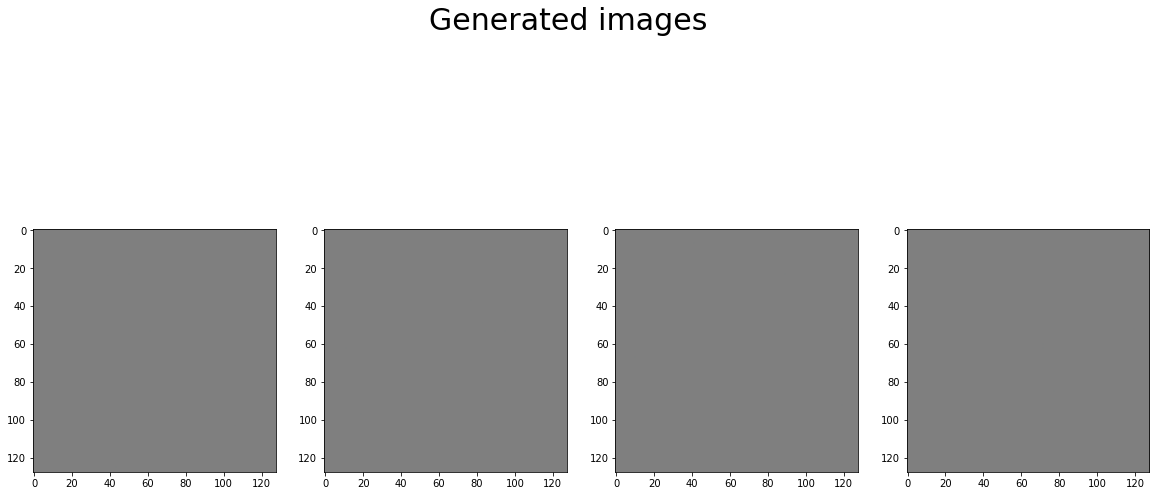

In [18]:
#https://fairyonice.github.io/My-first-GAN-using-CelebA-data.html
def get_noise(nsample=1, nlatent_dim=100):
    noise = np.random.normal(0, 1, (nsample,nlatent_dim))
    return(noise)

def plot_generated_images(noise,path_save=None,titleadd=""):
    imgs = generator.predict(noise)
    fig = plt.figure(figsize=(20,10))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1,nsample,i+1)
        ax.imshow(img)
    fig.suptitle("Generated images "+titleadd,fontsize=30)
    
    if path_save is not None:
        plt.savefig(path_save,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.close()
    else:
        plt.show()

nsample = 4
noise = get_noise(nsample=nsample, nlatent_dim=noise_shape[0])
plot_generated_images(noise)

In [19]:
z = layers.Input(shape=noise_shape)
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = models.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(0.00007, 0.5))
combined.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model (Model)                (None, 128, 128, 3)       8619715   
_________________________________________________________________
model_1 (Model)              (None, 1)                 126249249 
Total params: 134,868,964
Trainable params: 8,619,715
Non-trainable params: 126,249,249
_________________________________________________________________


In [20]:
def train(models, X_train, noise_plot, dir_result="./results_GAN/images",
          save_model_folder = "./results_GAN/models", epochs=10000, batch_size=128):
        '''
        models     : tuple containins three tensors, (combined, discriminator, generator)
        X_train    : np.array containing images (Nsample, height, width, Nchannels)
        noise_plot : np.array of size (Nrandom_sample_to_plot, hidden unit length)
        dir_result : the location where the generated plots for noise_plot are saved 
        
        '''
        combined, discriminator, generator = models
        nlatent_dim = noise_plot.shape[1]
        history = []
        batches = int(10000/64)+1
        for epoch in range(epochs):
            i = 0
            for image_batch in X_train:
              #batch = image_batch.numpy()
              # ---------------------
              #  Train Discriminator
              # ---------------------
              if i % 100 == 0:
                print(f"[Batch {i}/{batches}]")
              images = image_batch[0]
              noise = get_noise(images.shape[0], nlatent_dim)
              i += 1
              # Generate a half batch of new images
              gen_imgs = generator.predict(noise)

              
              # Train the discriminator q: better to mix them together?
              d_loss_real = discriminator.train_on_batch(images, np.ones((images.shape[0], 1)))
              d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((images.shape[0], 1)))
              d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


              # ---------------------
              #  Train Generator
              # ---------------------

              noise = get_noise(batch_size, nlatent_dim)

              # The generator wants the discriminator to label the generated samples
              # as valid (ones)
              valid_y = (np.array([1] * batch_size)).reshape(batch_size,1)
              
              # Train the generator
              g_loss = combined.train_on_batch(noise, valid_y)

              history.append({"D":d_loss[0],"G":g_loss})
            

            if epoch % 10 == 0 or epoch == epochs - 1 :
                print("storing weights on epoc " +  str(epoch))
                combined.save_weights(save_model_folder + '/combined_checkpoint')
                discriminator.save_weights(save_model_folder + '/discriminator_checkpoint')
                generator.save_weights(save_model_folder + '/generator_checkpoint')
                
            print ("Epoch {:05.0f} [D loss: {:4.3f}, acc.: {:05.1f}%] [G loss: {:4.3f}]".format(
                    epoch, d_loss[0], 100*d_loss[1], g_loss))
            plot_generated_images(noise_plot,
                                  titleadd="Epoch {}".format(epoch))
            plot_generated_images(noise_plot,
                                      path_save=dir_result+"/image_{:05.0f}.png".format(epoch),
                                      titleadd="Epoch {}".format(epoch))
                        
        return(history)


In [21]:

dir_result="./results_GAN/images"


In [22]:
X_train = training_dataset

In [23]:
# total = 0
# for batch in training_dataset:
#   total += 1
#   print(total)
#   print(batch.shape)

In [24]:
_models = combined, discriminator, generator          

[Batch 0/157]
[Batch 100/157]
storing weights on epoc 0
Epoch 00000 [D loss: 0.343, acc.: 100.0%] [G loss: 0.700]


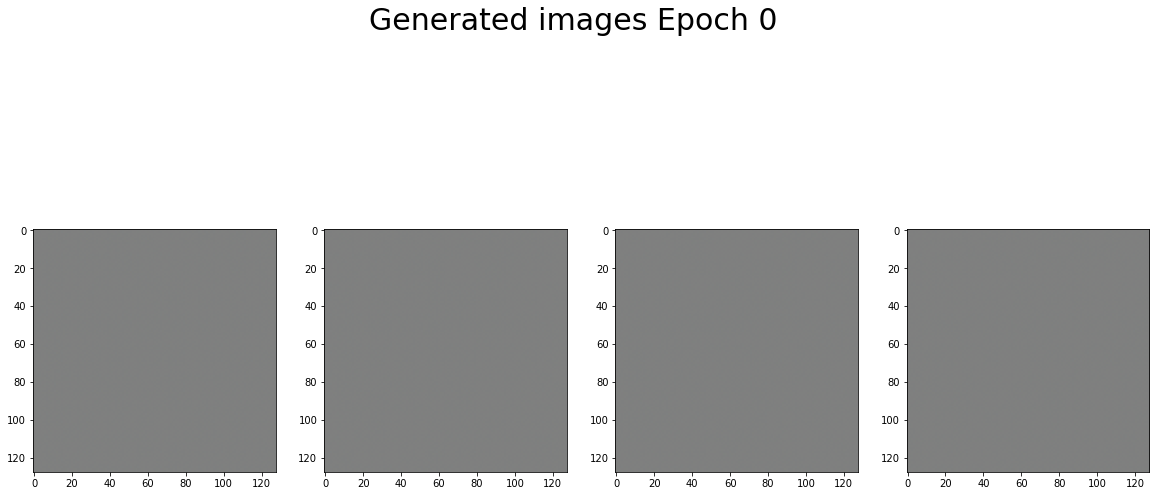

[Batch 0/157]
[Batch 100/157]
Epoch 00001 [D loss: 0.340, acc.: 100.0%] [G loss: 0.707]


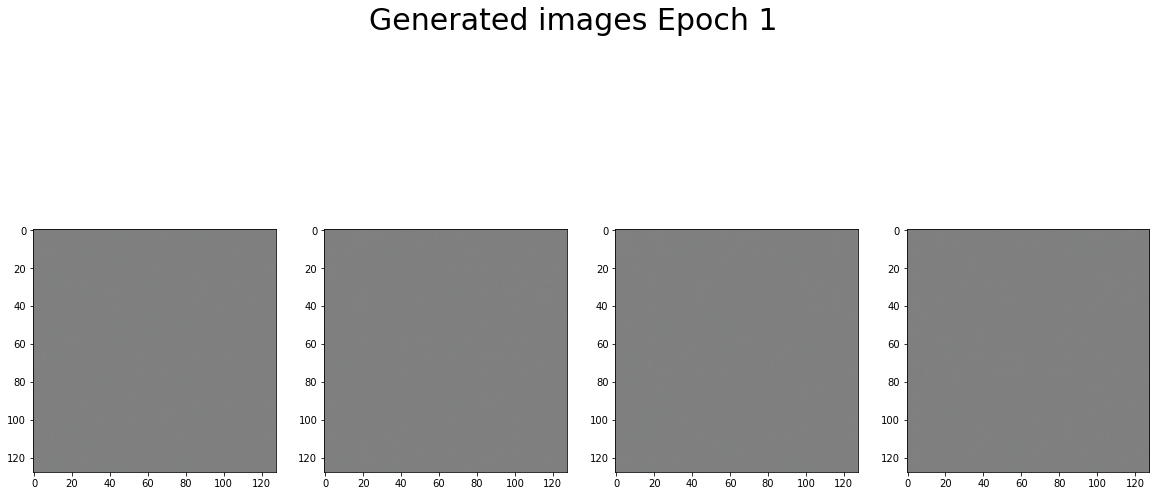

[Batch 0/157]
[Batch 100/157]
Epoch 00002 [D loss: 0.336, acc.: 100.0%] [G loss: 0.715]


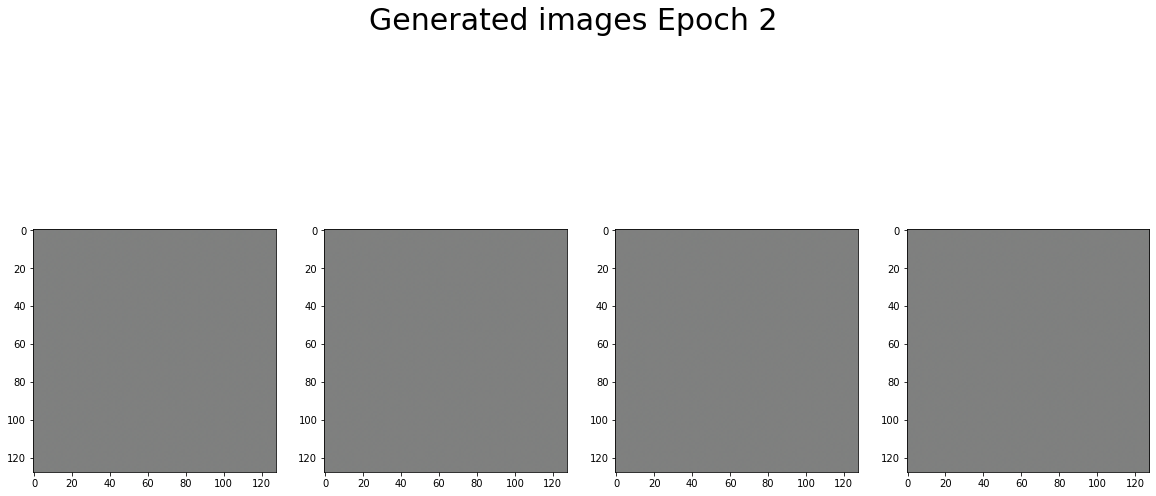

[Batch 0/157]
[Batch 100/157]
Epoch 00003 [D loss: 0.332, acc.: 100.0%] [G loss: 0.723]


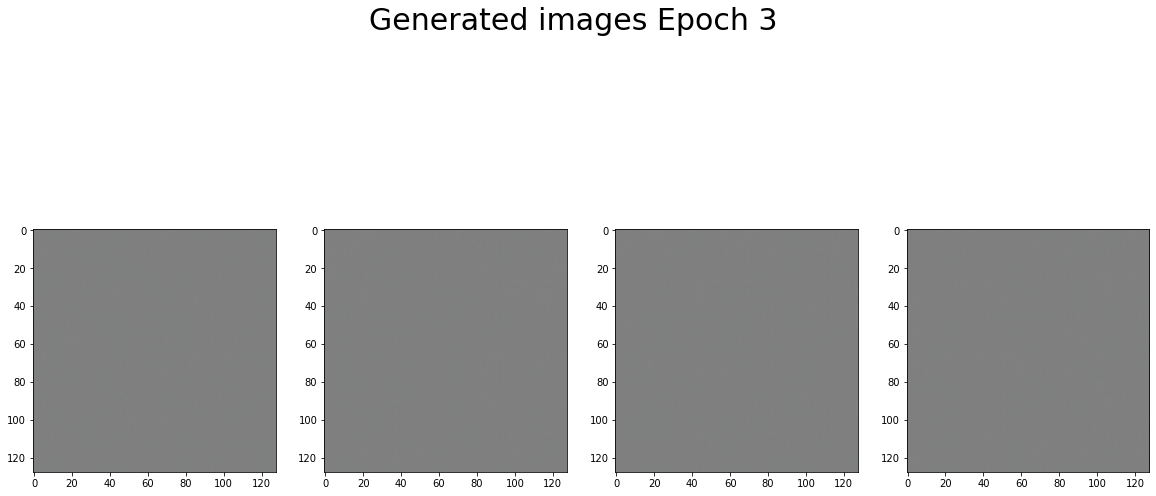

[Batch 0/157]
[Batch 100/157]
Epoch 00004 [D loss: 0.328, acc.: 100.0%] [G loss: 0.731]


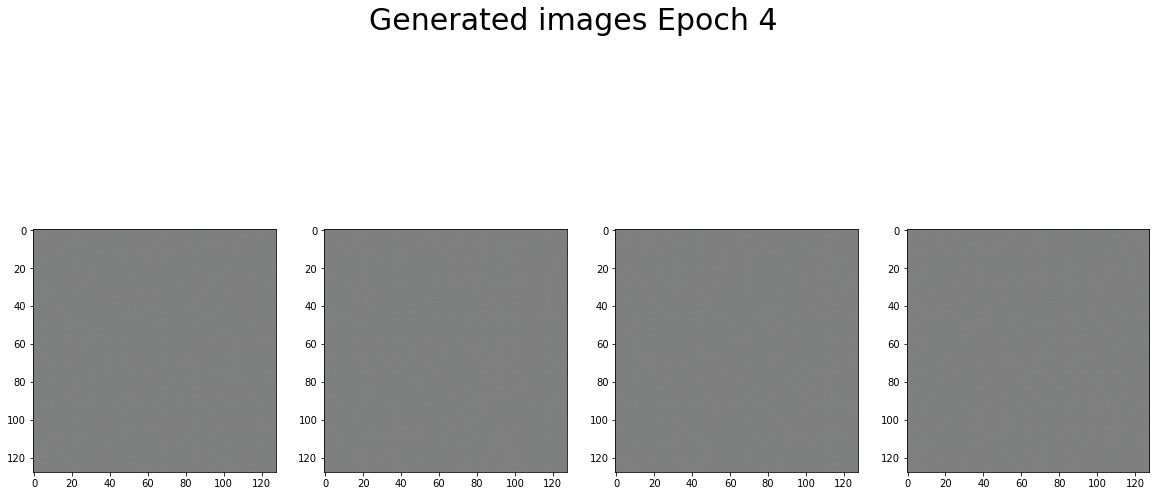

[Batch 0/157]
[Batch 100/157]
Epoch 00005 [D loss: 0.325, acc.: 100.0%] [G loss: 0.739]


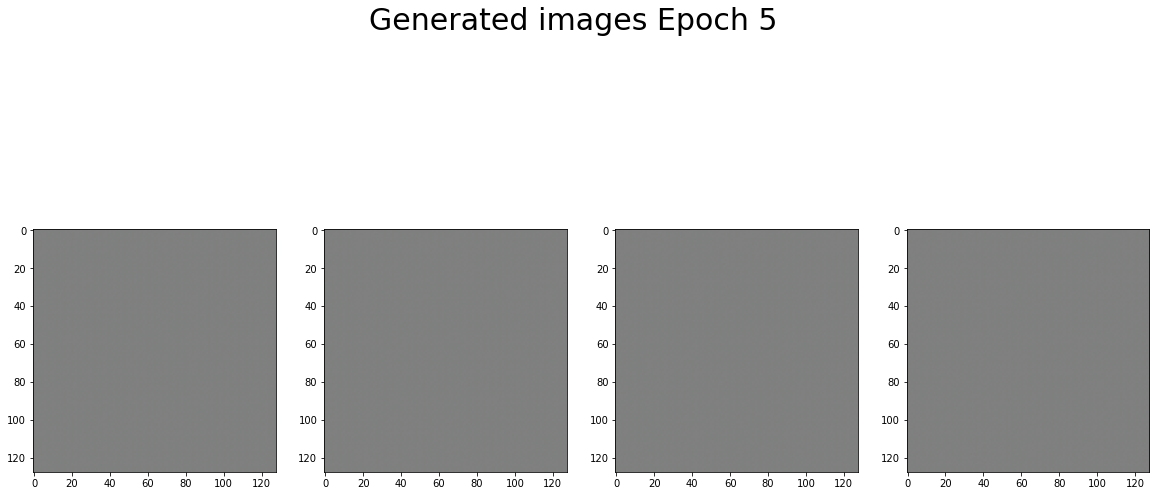

[Batch 0/157]
[Batch 100/157]
Epoch 00006 [D loss: 0.321, acc.: 100.0%] [G loss: 0.747]


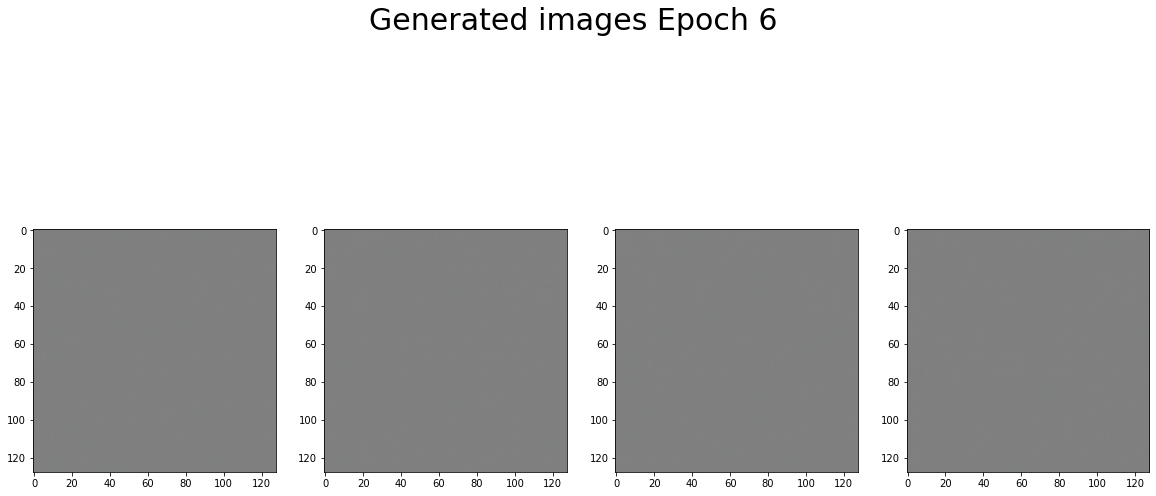

[Batch 0/157]
[Batch 100/157]
Epoch 00007 [D loss: 0.318, acc.: 100.0%] [G loss: 0.755]


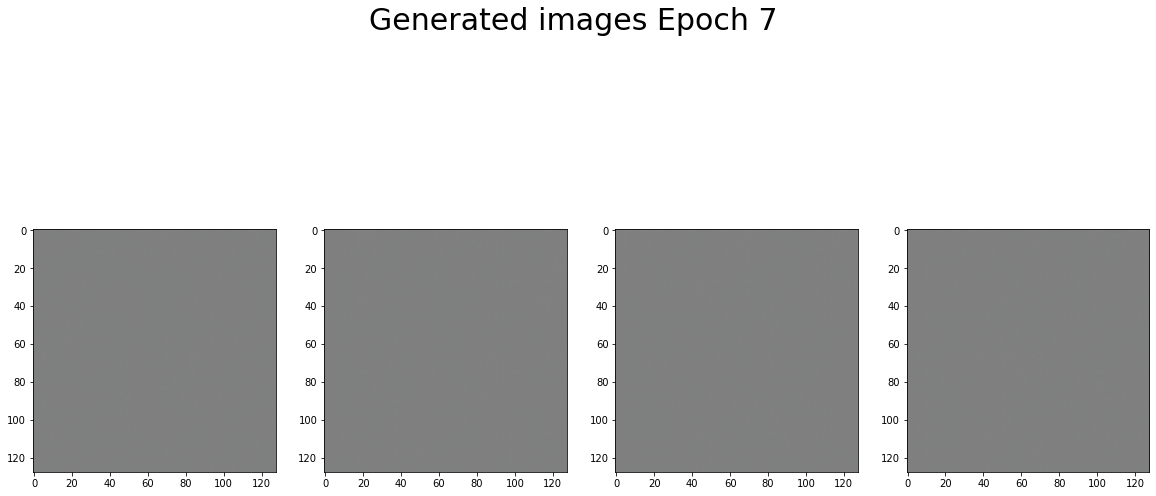

[Batch 0/157]
[Batch 100/157]
Epoch 00008 [D loss: 0.314, acc.: 100.0%] [G loss: 0.763]


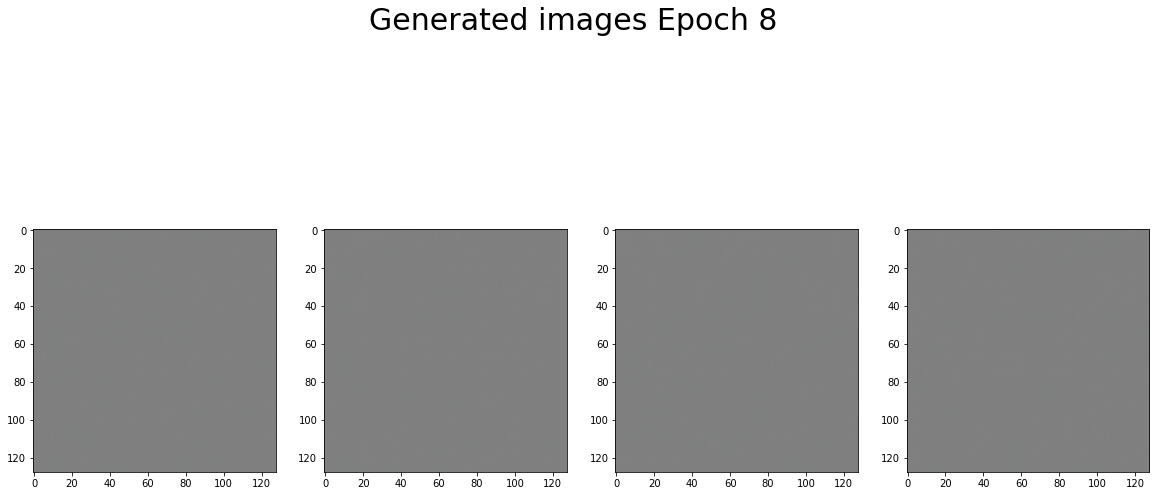

[Batch 0/157]
[Batch 100/157]
Epoch 00009 [D loss: 0.310, acc.: 100.0%] [G loss: 0.771]


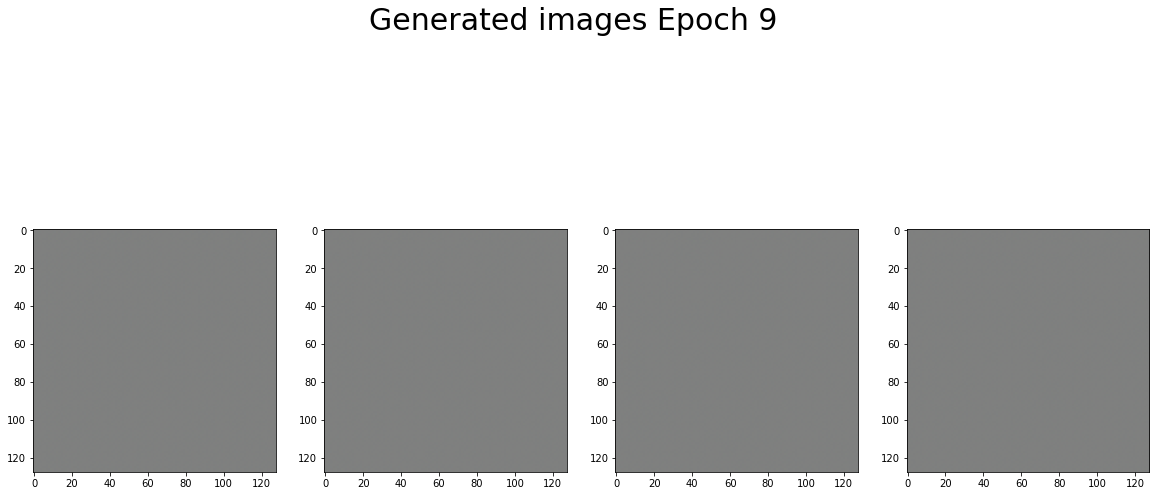

[Batch 0/157]
[Batch 100/157]
storing weights on epoc 10
Epoch 00010 [D loss: 0.307, acc.: 100.0%] [G loss: 0.779]


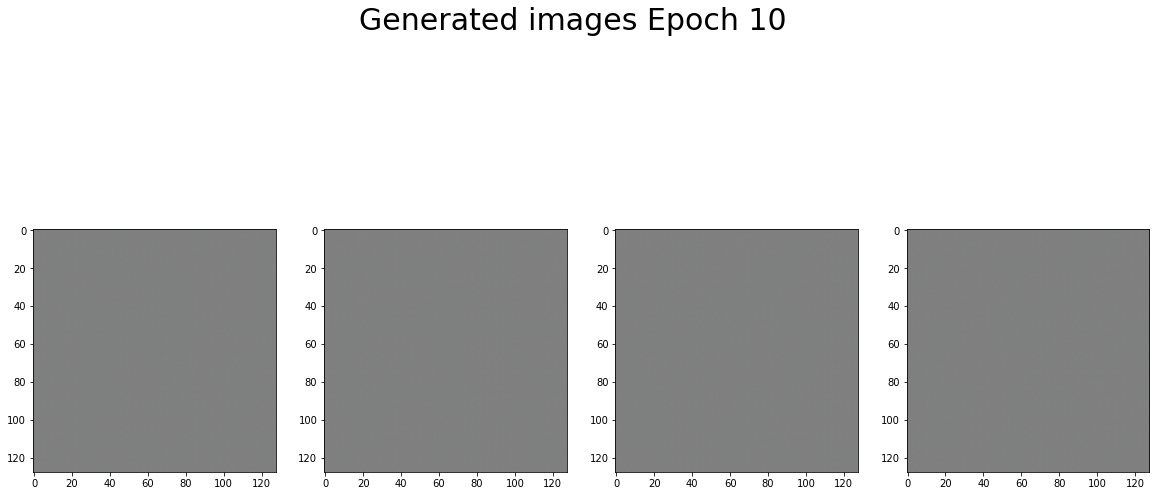

[Batch 0/157]
[Batch 100/157]
Epoch 00011 [D loss: 0.304, acc.: 100.0%] [G loss: 0.787]


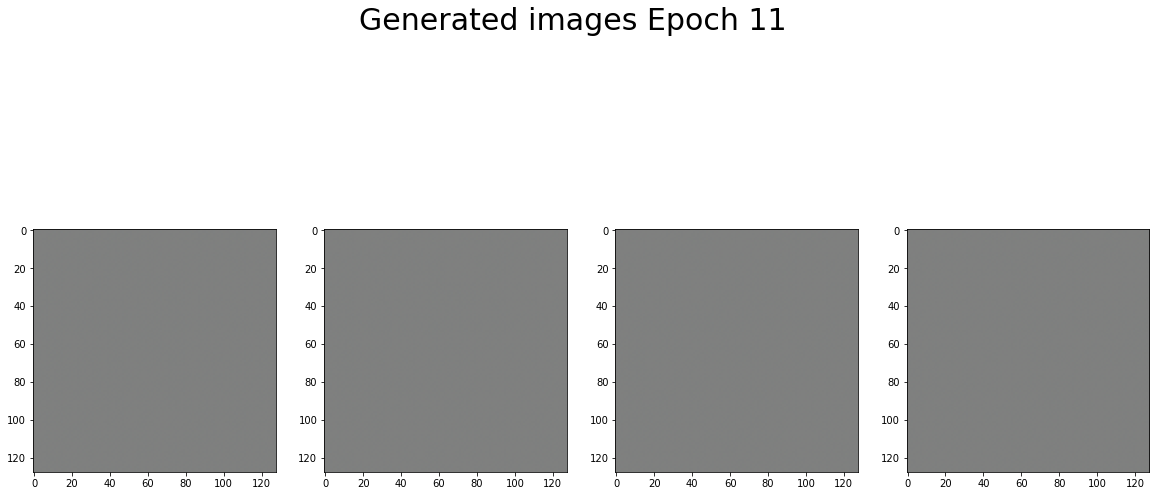

[Batch 0/157]
[Batch 100/157]
Epoch 00012 [D loss: 0.300, acc.: 100.0%] [G loss: 0.796]


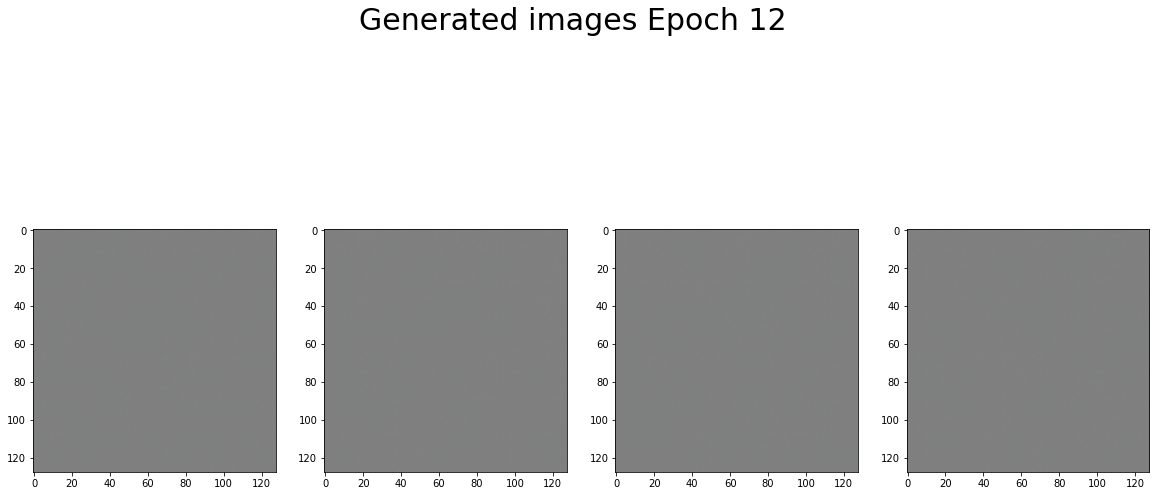

[Batch 0/157]
[Batch 100/157]
Epoch 00013 [D loss: 0.297, acc.: 100.0%] [G loss: 0.804]


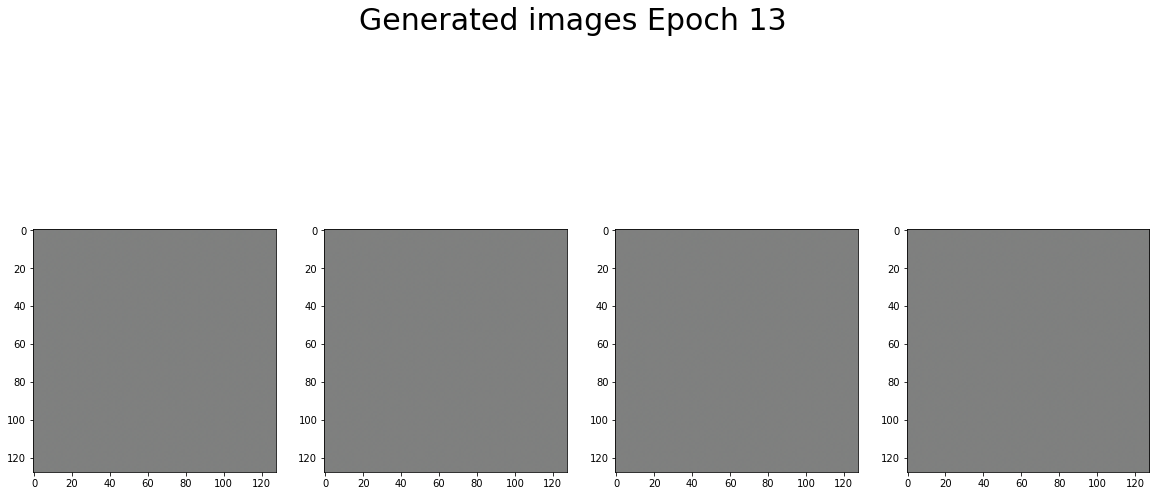

[Batch 0/157]
[Batch 100/157]
Epoch 00014 [D loss: 0.293, acc.: 100.0%] [G loss: 0.812]


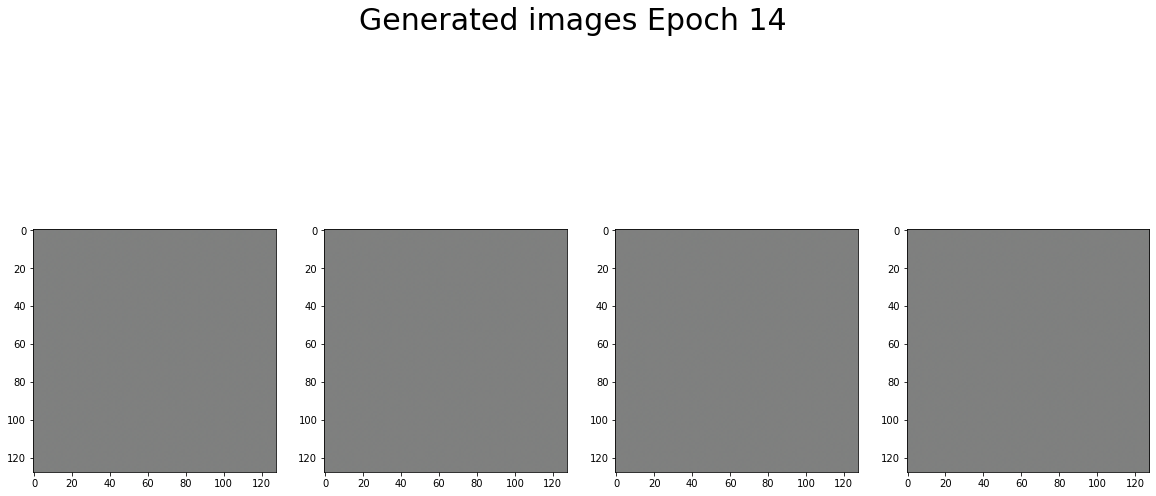

[Batch 0/157]
[Batch 100/157]
Epoch 00015 [D loss: 0.290, acc.: 100.0%] [G loss: 0.821]


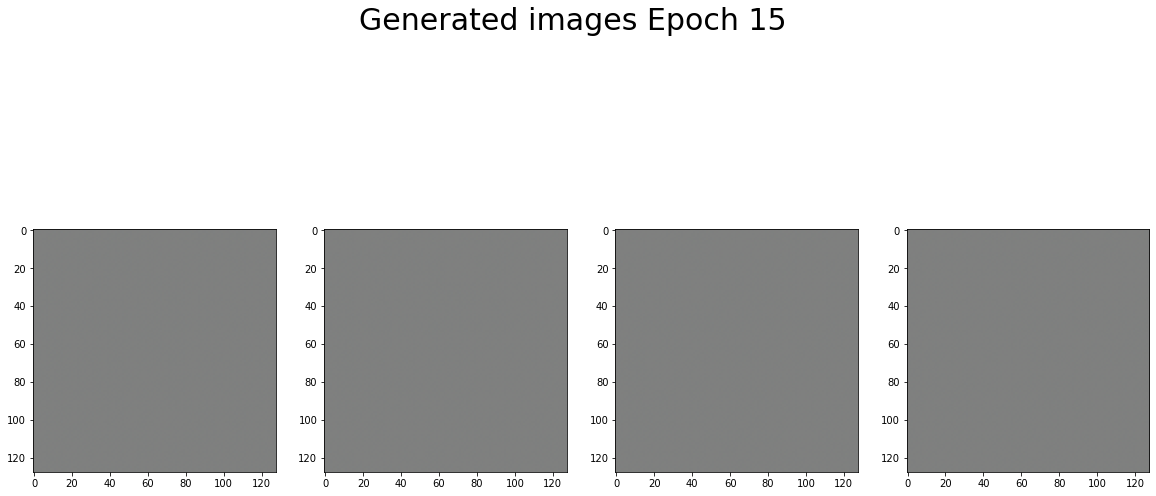

[Batch 0/157]
[Batch 100/157]
Epoch 00016 [D loss: 0.287, acc.: 100.0%] [G loss: 0.829]


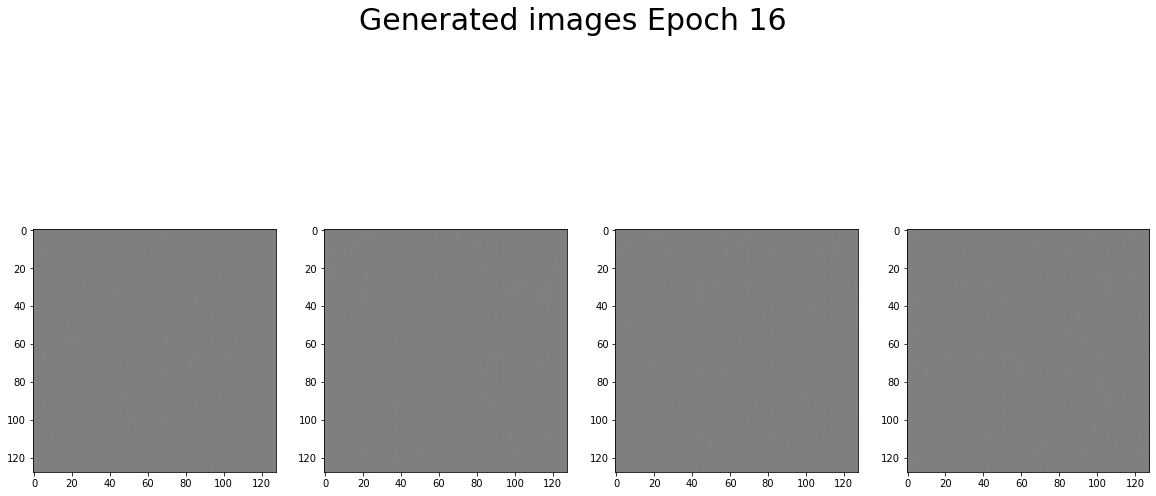

[Batch 0/157]
[Batch 100/157]
Epoch 00017 [D loss: 0.283, acc.: 100.0%] [G loss: 0.838]


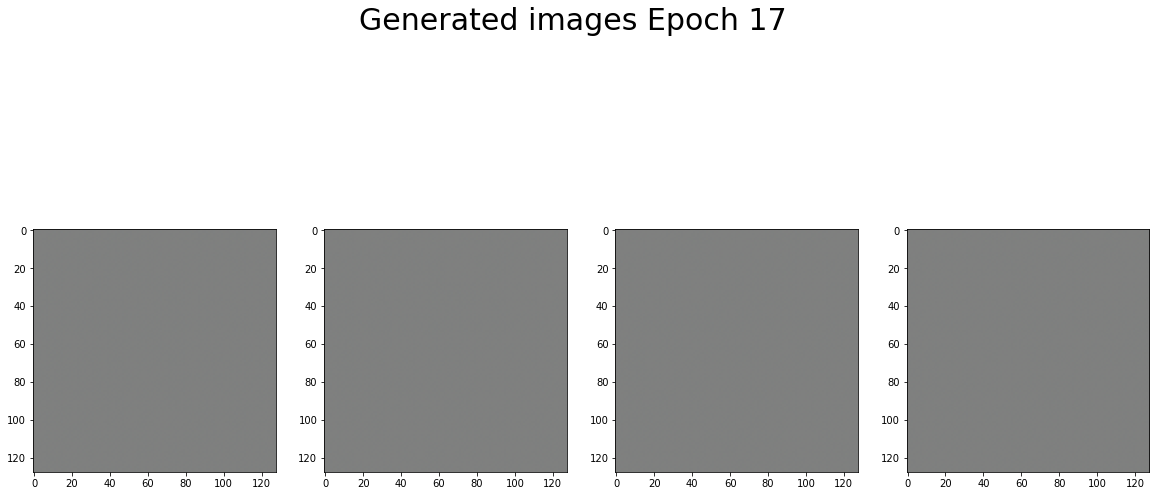

[Batch 0/157]
[Batch 100/157]
Epoch 00018 [D loss: 0.280, acc.: 100.0%] [G loss: 0.847]


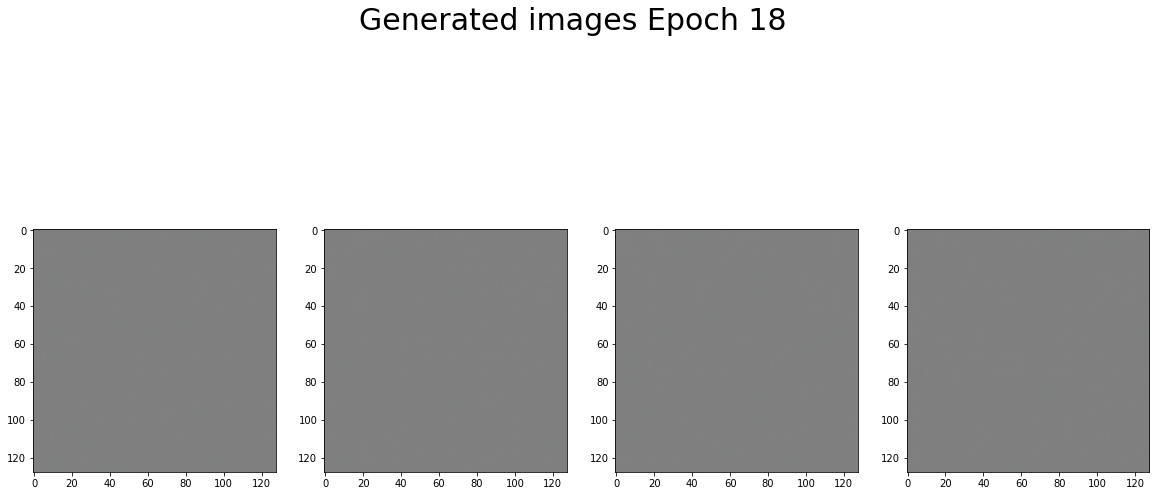

[Batch 0/157]
[Batch 100/157]
Epoch 00019 [D loss: 0.277, acc.: 100.0%] [G loss: 0.855]


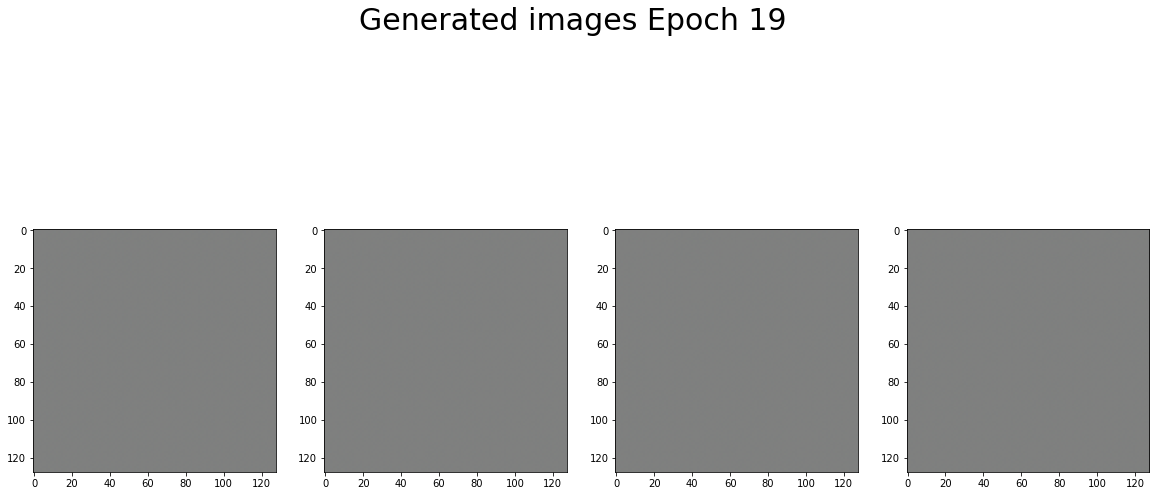

[Batch 0/157]
[Batch 100/157]
storing weights on epoc 20
Epoch 00020 [D loss: 0.274, acc.: 100.0%] [G loss: 0.864]


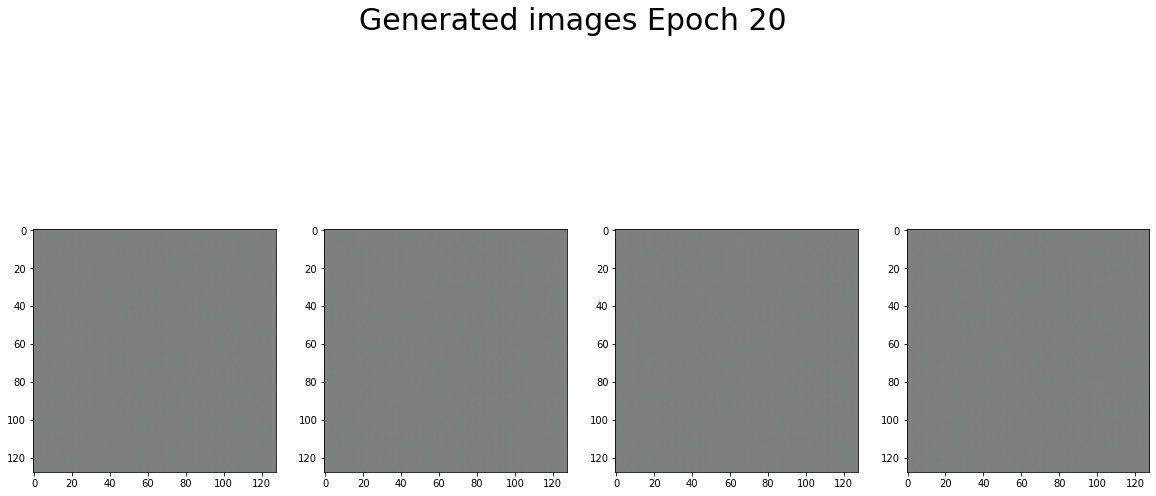

[Batch 0/157]
[Batch 100/157]
Epoch 00021 [D loss: 0.271, acc.: 100.0%] [G loss: 0.873]


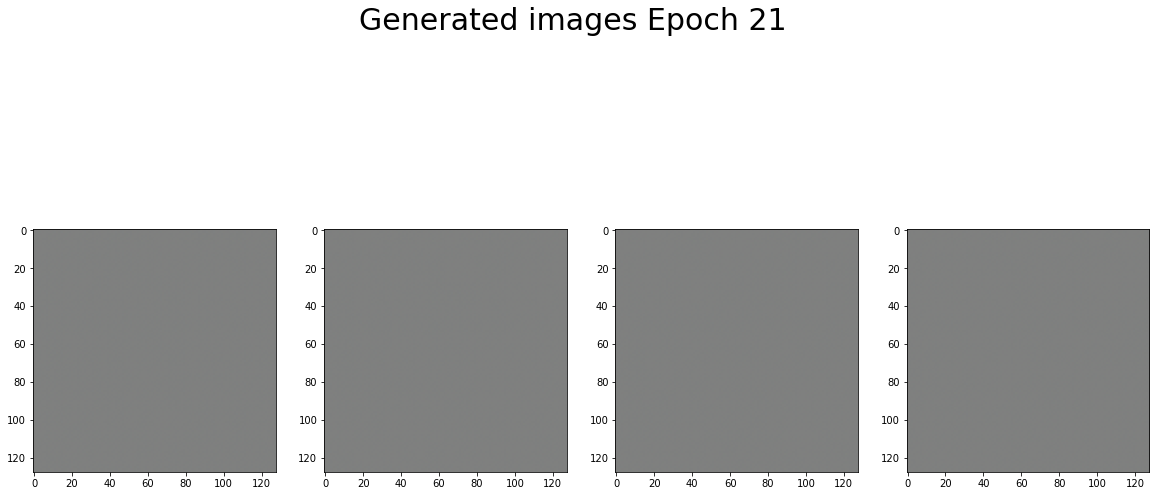

[Batch 0/157]
[Batch 100/157]
Epoch 00022 [D loss: 0.267, acc.: 100.0%] [G loss: 0.882]


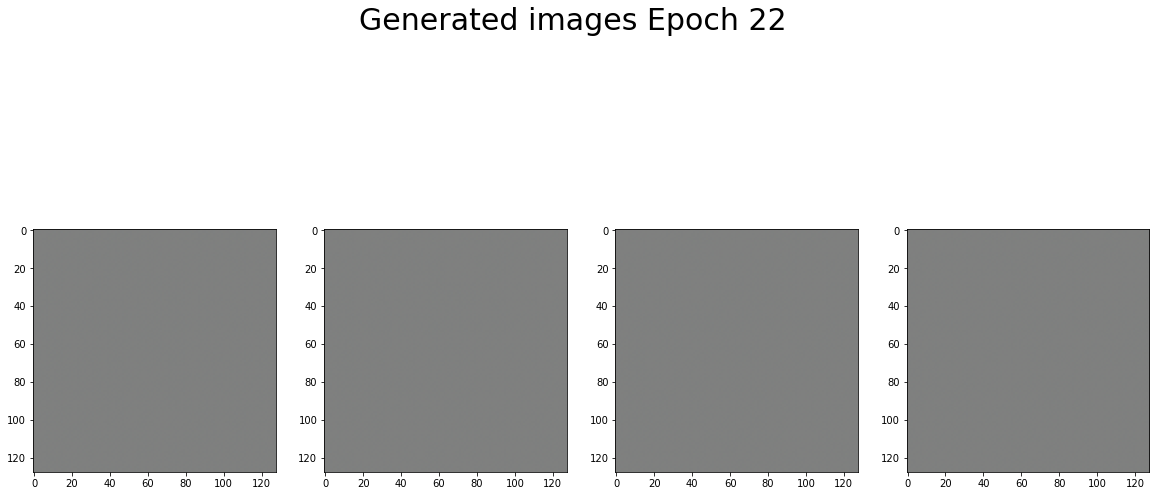

[Batch 0/157]
[Batch 100/157]
Epoch 00023 [D loss: 0.264, acc.: 100.0%] [G loss: 0.890]


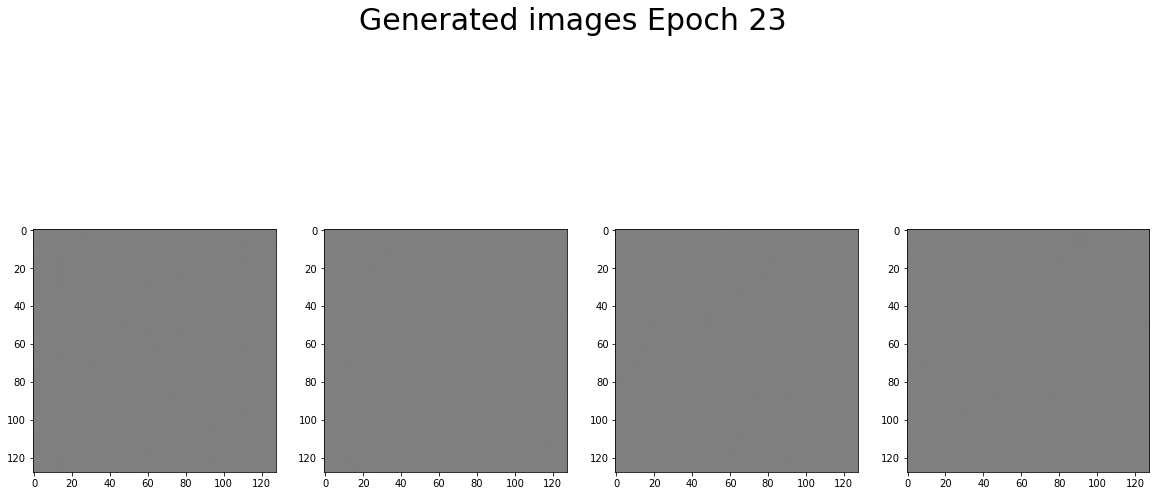

[Batch 0/157]
[Batch 100/157]
Epoch 00024 [D loss: 0.261, acc.: 100.0%] [G loss: 0.899]


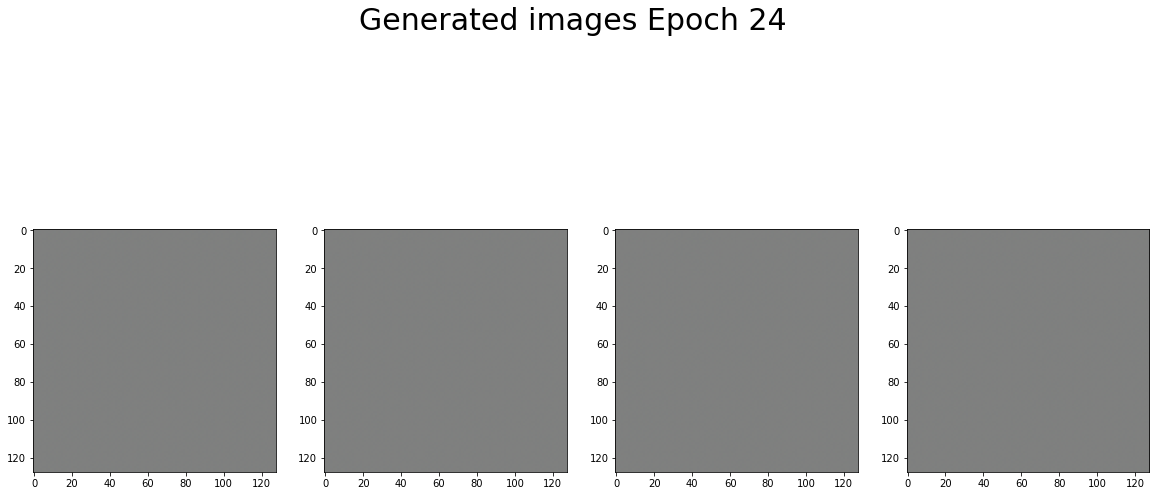

[Batch 0/157]
[Batch 100/157]
Epoch 00025 [D loss: 0.258, acc.: 100.0%] [G loss: 0.908]


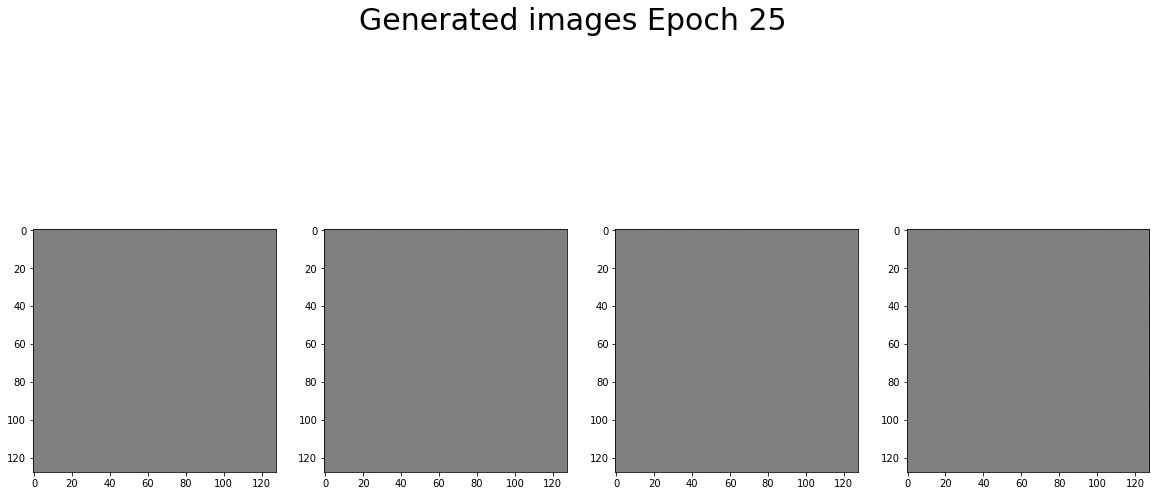

[Batch 0/157]
[Batch 100/157]
Epoch 00026 [D loss: 0.255, acc.: 100.0%] [G loss: 0.917]


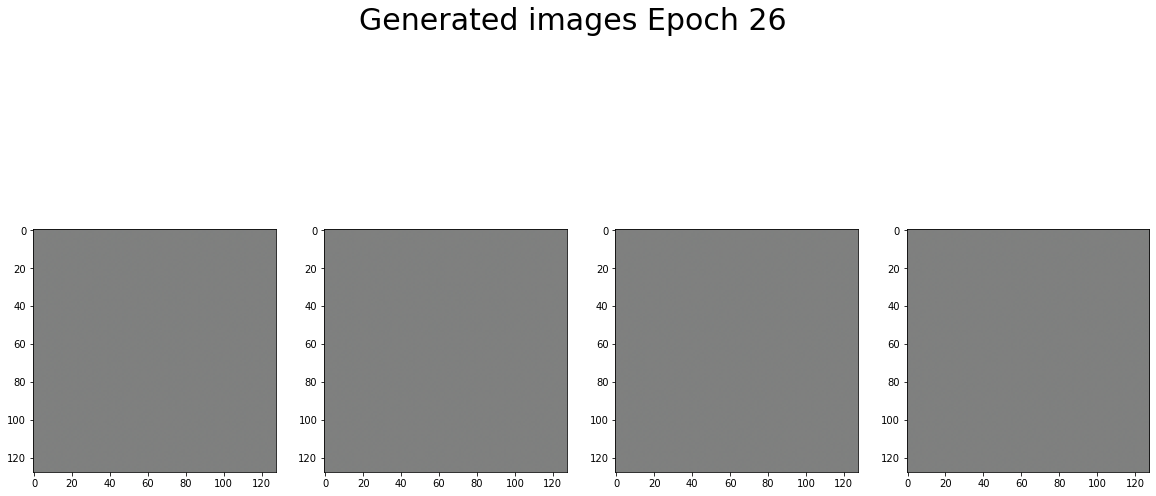

[Batch 0/157]
[Batch 100/157]
Epoch 00027 [D loss: 0.252, acc.: 100.0%] [G loss: 0.926]


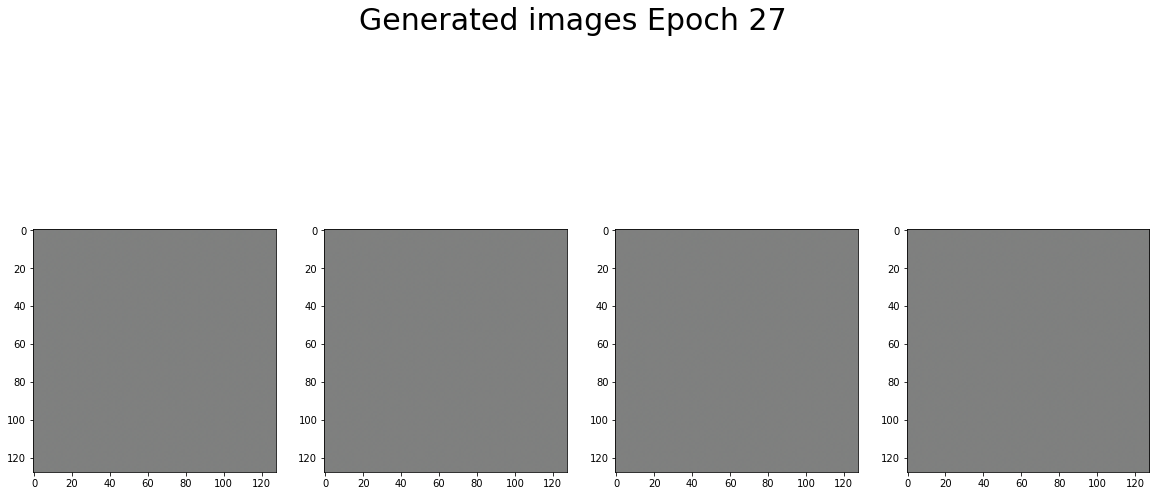

[Batch 0/157]
[Batch 100/157]
Epoch 00028 [D loss: 0.249, acc.: 100.0%] [G loss: 0.936]


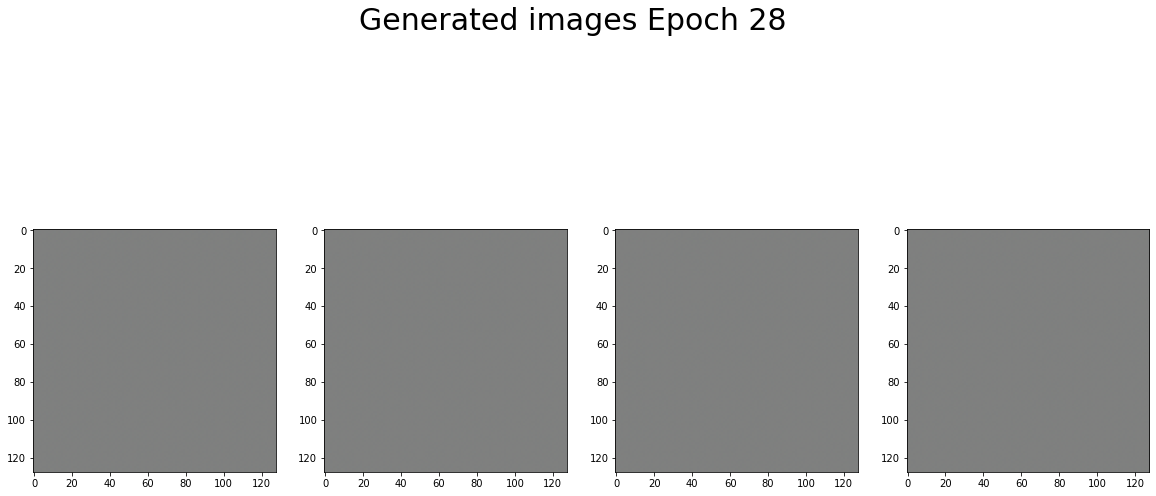

[Batch 0/157]
[Batch 100/157]
Epoch 00029 [D loss: 0.246, acc.: 100.0%] [G loss: 0.945]


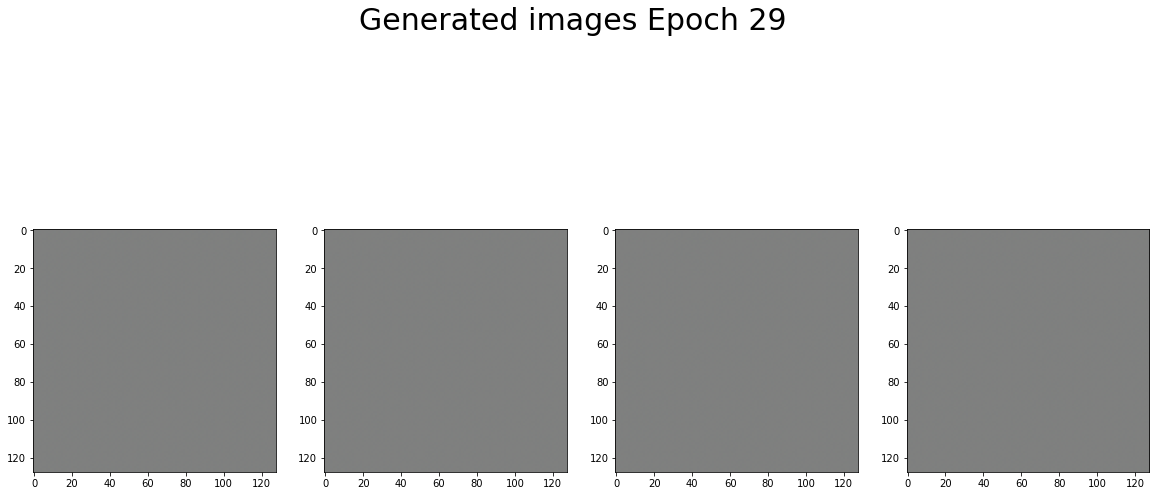

[Batch 0/157]
[Batch 100/157]
storing weights on epoc 30
Epoch 00030 [D loss: 0.243, acc.: 100.0%] [G loss: 0.954]


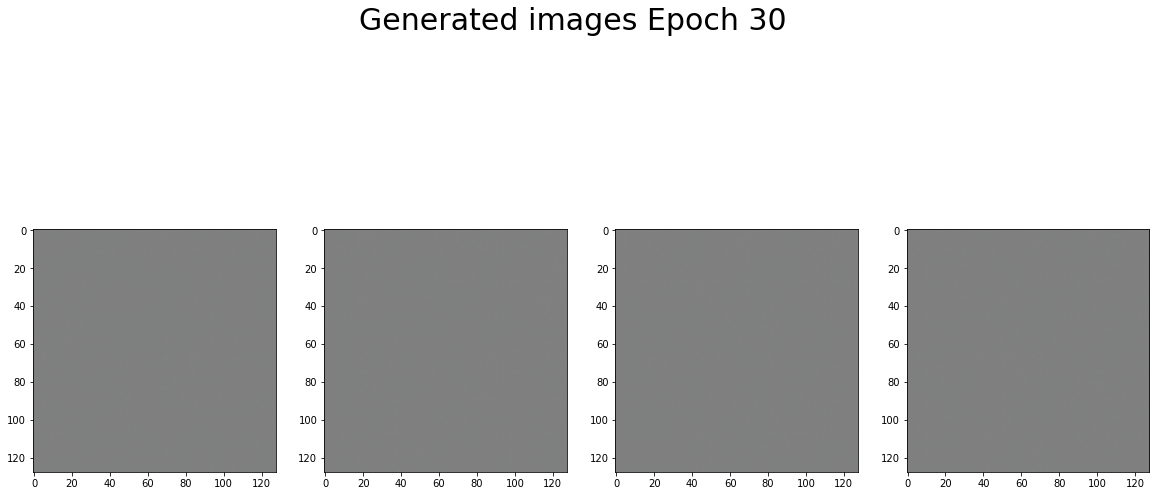

[Batch 0/157]
[Batch 100/157]
Epoch 00031 [D loss: 0.240, acc.: 100.0%] [G loss: 0.963]


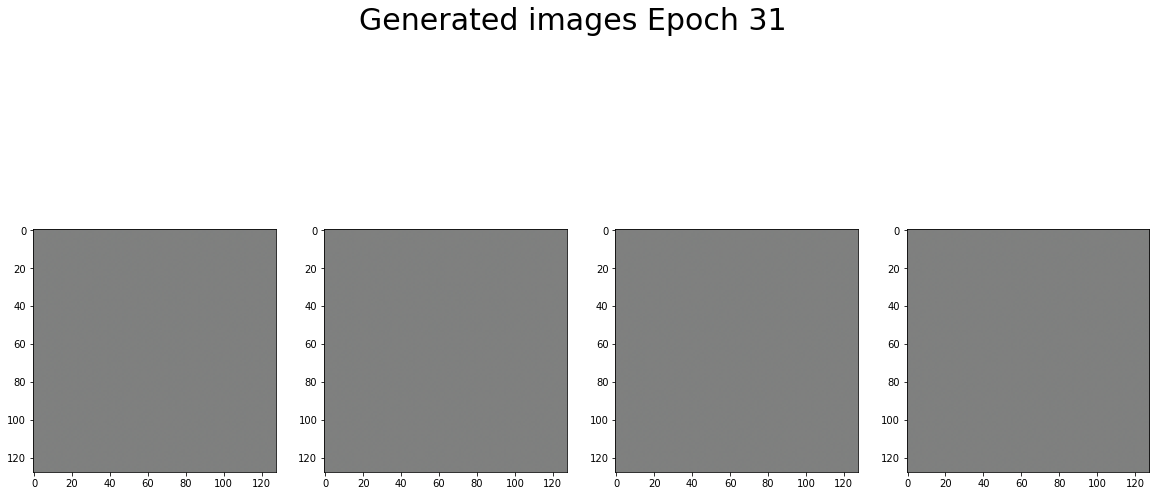

[Batch 0/157]
[Batch 100/157]
Epoch 00032 [D loss: 0.237, acc.: 100.0%] [G loss: 0.973]


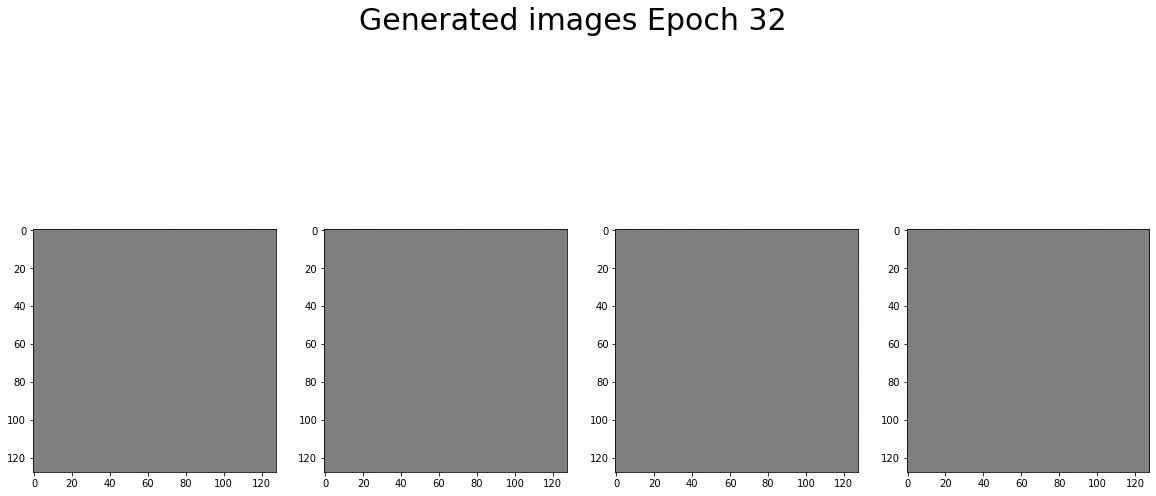

[Batch 0/157]
[Batch 100/157]
Epoch 00033 [D loss: 0.235, acc.: 100.0%] [G loss: 0.982]


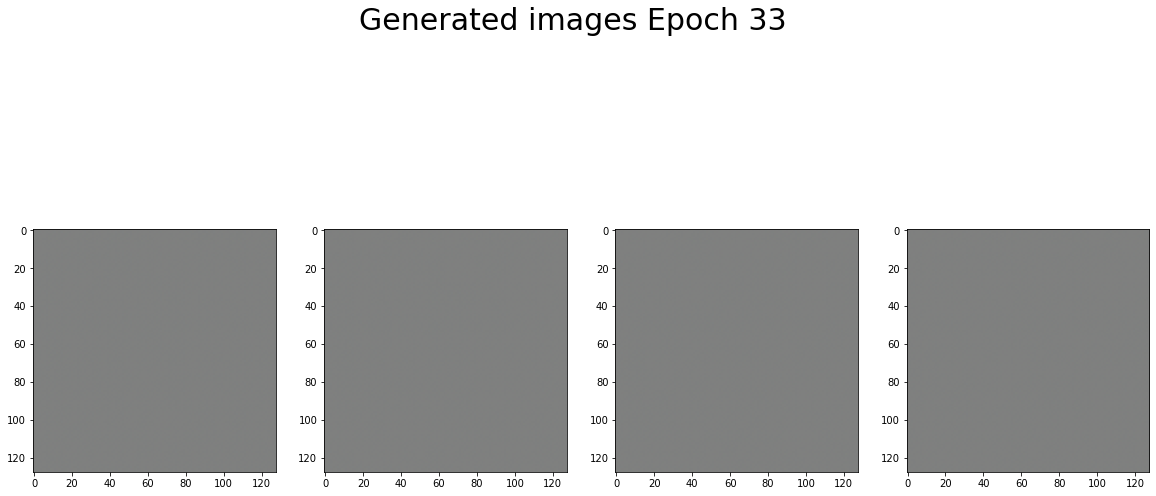

[Batch 0/157]
[Batch 100/157]


In [ ]:
with tf.device('/device:GPU:0'):
  start_time = time.time()
  history = train(_models, X_train, noise,epochs=2200, batch_size=64)
  end_time = time.time()
  print("-"*10)
  print("Time took: {:4.2f} min".format((end_time - start_time)/60))

#Continue